# Исследование надежности заемщиков.

Задачи, поставленные в рамках данного исследования: <br>
1) Выяснить, имеется ли зависимость между: <br>
    - количеством детей и возвратом кредита в срок <br>
    - семейным положением и возвратом кредита в срок <br>
    - уровнем дохода и возвратом кредита в срок <br>
2) Выяснить, как разные цели кредита влияют на его возврат в срок <br>
3) На основании выявленных зависимостей сделать предложения для улучшения методики расчета индивидуального кредитного скоринга клиентов.

## Обзор данных

In [1]:
import pandas as pd
import seaborn as sb
data = pd.read_csv('/datasets/data.csv')
data.info()
display(data.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


## Предобработка данных

### Заполнение пропусков

In [2]:
missed_total_income = data[data['total_income'].isna() == True]['income_type'].count() #подсчет количества значений NaN в колонке total_income
share_missed_total_income = data[data['total_income'].isna() == True]['income_type'].count() / data['income_type'].count()
display(f'Количество пропущенных значений в столбце total_income {missed_total_income}')
display(f'Доля пропущенных значений в столбце total_income{share_missed_total_income: .1%}')

income_median = data['total_income'].median()

#расчет медианы по каждой категории для последующего заполнения ими значений стажа
display(data.groupby(by='income_type')['total_income'].median())

def inc_median_filler(total_income):       #cоздание функции, присваивающей значение медианы в заивисмости от категории дохода
    if total_income == 'безработный' : 
        return  131339.751676 
    elif total_income == 'в декрете' : 
        return 53829.130729
    elif total_income =='госслужащий' : 
        return 145017.937533
    elif total_income == 'компаньон' : 
        return 162439.637095
    elif total_income == 'пенсионер' : 
        return 128621.510044
    elif total_income == 'предприниматель' : 
        return 322090.541240
    elif total_income == 'сотрудник' : 
        return 145017.937533
    elif total_income == 'студент' : 
        return 98201.625314

data['income_median'] = data['income_type'].apply(inc_median_filler)
data['total_income'] = data['total_income'].fillna(data['income_median'])

data['total_income'].isnull().sum() #проверка количества оставшихся nullевых значений

'Количество пропущенных значений в столбце total_income 2174'

'Доля пропущенных значений в столбце total_income 10.1%'

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64

0

**Комментарий к шагу 2.1** <br>
1) В столбце total_income 2174 пропущенных значений, что составляет 10% от общего количества строк. Т.к. количество значений достаточно велико, то нельзя их просто исключить из выборки - необходимо заполнить их симулированными значениями. <br> <br>
2) Исходя из сэмпла строк с пропущенными значениями, можно сделать вывод, что пропущенные значения в столбце доходов связаны с пропущенными значениями в столбце days_employed (количество отработанных дней).<br>
Вероятно, данные были пропущены при копировании или же были рассчитаны по формуле, завязанной на значение колонки days_employed. <br><br>
3) В данном случае заполнение медианным значением по типу дохода является оптимальным решением, т.к. медиана является наиболее репрезентативной при наличии большой выборки и существенного разброса значений, а также в данном случае позволяет учесть разницу в доходах различных категорий занятости.

### Проверка данных на аномалии и исправления.

In [3]:
#проверка на аномалии столбца children
data['children'].value_counts()
mistakes_children = data[(data['children'] == 20) | (data['children'] == -1)]['gender'].count()
mistakes_children_rate = data[(data['children'] == 20) | (data['children'] == -1)]['gender'].count() / data['gender'].count()
display(f'Общее число ошибочных линий в колонке children: {mistakes_children}, что составляет {mistakes_children_rate :.01%}')
data = data.loc[(data['children'] >= 0) & (data['children'] <20)] # т.к. количество ошибочных данных в этой колонке составляет всего 0,6%, их потеря не является критичной, поэтому мы можем удалить эти данные ииз датасета путем перезаписи

'Общее число ошибочных линий в колонке children: 123, что составляет 0.6%'

In [4]:
#проверка на аномалии столбца days_employed
#значения days_employed должны соответствовать следующим параметрам: 1. не быть NaN, 2.быть больше нуля, 3. быть меньше dob_years - 14*, переведенных в дни; * - 14 это минимально допустимый возраст начала стажа

#проверка первого пункта:
data['days_employed'].isna().sum() # --> 2162 строки с NaN, это много, т.ч. их нельзя убирать из датасета; необходимо заменить их на медианное значение по категориям

#проверка второго пункта
data[data['days_employed'] < 0]['days_employed'].count() # --> 15735 строк с отрицательными значениями = большинство! очевидно, надо заменить их на такие же положительные
data['days_employed'] = abs(data['days_employed']) #берем все значения по модулю

#проверка третьего пункта
data[data['days_employed'] > (data['dob_years']-14)*365]['dob_years'].count() # --> 3430 строк с такими значениями, необходимо установить их происхождение
data['income_type'].value_counts()
data[data['days_employed'] > (data['dob_years']-14)*365]['income_type'].value_counts() #--> основная проблема среди пенсионеров (3412 из 3792)

#посчитаем медианы по каждой категории для последующего заполнения ими значений стажа
display(data.groupby(by='income_type')['days_employed'].median())

def median_filler(income_type):       #cоздание функции, присваивающей значение медианы в заивисмости от категории дохода
    if income_type == 'безработный' : 
        return 366413.652744 
    elif income_type == 'в декрете' : 
        return 3296.759962
    elif income_type =='госслужащий' : 
        return 2689.137274
    elif income_type == 'компаньон' : 
        return 1555.947387
    elif income_type == 'пенсионер' : 
        return 365286.622650
    elif income_type == 'предприниматель' : 
        return 520.848083
    elif income_type == 'сотрудник' : 
        return 1572.328285
    elif income_type == 'студент' : 
        return 578.751554

data['new_median'] = data['income_type'].apply(median_filler)
data['days_employed'] = data['days_employed'].fillna(data['new_median'])

data['days_employed'].isnull().sum() #проверка количества оставшихся nullевых значения

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.137274
компаньон            1555.947387
пенсионер          365286.622650
предприниматель       520.848083
сотрудник            1572.328285
студент               578.751554
Name: days_employed, dtype: float64

0

In [5]:
#проверка на аномалии столбца dob_years
data['dob_years'].unique()
mistakes_dob_years = data['dob_years'].nunique()
mistakes_dob_years_rate = (data['dob_years'].nunique())/ (data['gender'].count())
display(f'Общее число ошибочных линий в колонке dob_years {mistakes_dob_years}, что составляет {mistakes_dob_years_rate :.01%}')
data = data[data['dob_years'] != 0] # т.к. количество ошибочных данных в этой колонке составляет всего 0,3%, их потеря не является критичной, поэтому мы можем удалить эти данные ииз датасета путем перезаписи

'Общее число ошибочных линий в колонке dob_years 58, что составляет 0.3%'

In [6]:
#проверка на аномалии столбцов education & education_id
data['education_id'].value_counts()
data.groupby(by='education')[['education','education_id']].count() # нет несоответствий между данными education_id & education

,education,education_id
education,,
ВЫСШЕЕ,270,270
Высшее,266,266
НАЧАЛЬНОЕ,17,17
НЕОКОНЧЕННОЕ ВЫСШЕЕ,29,29
Начальное,15,15
Неоконченное высшее,47,47
СРЕДНЕЕ,764,764
Среднее,700,700
УЧЕНАЯ СТЕПЕНЬ,1,1


In [7]:
#проверка на аномалии столбцов family_status & family_status_id
data['family_status'].value_counts()
data.groupby(by='family_status_id')[['family_status','family_status_id']].count() # нет несоответствий между данными education_id & education

,family_status,family_status_id
family_status_id,,
0,12254,12254
1,4139,4139
2,947,947
3,1179,1179
4,2783,2783


In [8]:
#проверка на аномалии столбца gender
display(data['gender'].unique()) # аномальное значение в графе "пол"
data[data['gender']== 'XNA']['gender'].count() #подсчет кол-ва строк с аномалией (1 строка)
data = data.loc[data['gender'] != 'XNA'] # можем убрать эту строку, т.к. это не повлияет на расчет


array(['F', 'M', 'XNA'], dtype=object)

In [9]:
#проверка на аномалии столбцов debt, income_type, purpose
display(data['debt'].value_counts()) # OK
display(data['income_type'].value_counts()) # OK
display(data['purpose'].value_counts()) # есть относительные повторы, но не идентичные; они будут позже категоризированы

0    19577
1     1724
Name: debt, dtype: int64

сотрудник          10996
компаньон           5033
пенсионер           3819
госслужащий         1447
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           764
операции с недвижимостью                  670
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     644
операции с жильем                         642
покупка жилья для семьи                   639
жилье                                     636
покупка жилья                             635
недвижимость                              628
операции со своей недвижимостью           626
строительство собственной недвижимости    626
строительство недвижимости                620
строительство жилой недвижимости          619
покупка своего жилья                      618
покупка недвижимости                      615
ремонт жилью                              607
покупка жилой недвижимости                600
на покупку своего автомобиля              501
заняться высшим образованием      

**Комментарий к шагу 2.2**<br><br>
Проверка на аномалии дала нам следующую информацию: <br>
1) Поля debt, income_type, purpose, family_status, family_status_id, education, eduction_id не содержат аномалий и пропуском и могут быть использованы в работе полностью. <br><br>
2) Поле children содержит аномальные значения(-1 и 20), нехарактерные для данного столбца по смыслу. Поскольку количество аномальных значений небольшое, то их исключение из датасета не повлияет на качество анализа. <br>
Возможные причины возникновения аномалии: ошибки при ручном вводе или копировании из другого файла. <br><br>
3) Поле dob_years содержит в себе данные сомнительного качества - часть данных выражена отрицательной величиной, данные для пенсионеров  и безработных, вероятно, выражены в каких-то других единицах измерения (не дни). Поскольку этот столбец не принципиально важен для цели анализа, данные обработаны и приведены в порядок на основании догадок о происходждении аномалий. <br>
Возможной причиной возникновения ошибки является неправильное ведение базы данных по стажу. Необходимо выяснить точные причины возникновения аномалии и устранить их.<br><br>
4) Поле gender содержит аномальное значение XNA, поскольку количество минимально (1 строка), то эта строка была убрана из датасета.<br><br>
5) Поле total_income содержит определенное количество незаполненных значений. Т.к. это ключевой показатель, заполнение нулевых значений крайне важно. Для этого использовались медианные значения для каждой категории дохода, это позволило учесть различия в доходах разных категорий клиентов.


### Изменение типов данных.

In [10]:
data['total_income'] = data['total_income'].astype('int') # total_income переведен в целочисленные значения
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21301 non-null  int64  
 1   days_employed     21301 non-null  float64
 2   dob_years         21301 non-null  int64  
 3   education         21301 non-null  object 
 4   education_id      21301 non-null  int64  
 5   family_status     21301 non-null  object 
 6   family_status_id  21301 non-null  int64  
 7   gender            21301 non-null  object 
 8   income_type       21301 non-null  object 
 9   debt              21301 non-null  int64  
 10  total_income      21301 non-null  int64  
 11  purpose           21301 non-null  object 
 12  income_median     21301 non-null  float64
 13  new_median        21301 non-null  float64
dtypes: float64(3), int64(6), object(5)
memory usage: 2.4+ MB


### Удаление дубликатов.

In [11]:
#проверка на неяные дубликаты столбца education
data['education'].value_counts()
data['education'] = data['education'].str.lower() # приведение всех данных в столбце к нижнему регистру
data['education'].value_counts()

среднее                15073
высшее                  5202
неоконченное высшее      738
начальное                282
ученая степень             6
Name: education, dtype: int64

In [12]:
# подсчет и удаление явных дубликатов
data.duplicated().sum() # подсчет количества явных дубликатов
data = data.drop_duplicates() # удаление явных дубликатов
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21230 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21230 non-null  int64  
 1   days_employed     21230 non-null  float64
 2   dob_years         21230 non-null  int64  
 3   education         21230 non-null  object 
 4   education_id      21230 non-null  int64  
 5   family_status     21230 non-null  object 
 6   family_status_id  21230 non-null  int64  
 7   gender            21230 non-null  object 
 8   income_type       21230 non-null  object 
 9   debt              21230 non-null  int64  
 10  total_income      21230 non-null  int64  
 11  purpose           21230 non-null  object 
 12  income_median     21230 non-null  float64
 13  new_median        21230 non-null  float64
dtypes: float64(3), int64(6), object(5)
memory usage: 2.4+ MB


**Комментарий к шагу 2.4**

1) Анализ уникальных значений (*unique()*) в столбце education показал, что одни и те же значения внесены с различным регистром. Все значения в этом столбце были приведены в нижний регистр. Остальные столбцы были проверены в шаге 2.3 и не содержат повторяющихся значений с различающимся регистром. <br>
После этого можно приступать к удалению явных дубликатов (которые могли быть скрыты от фильтра при помощи регистра) методом drop_duplicates().<br>
2) Причина возникновения дубликатов в датасете скорее всего носит технологический характер - задвоение данных при выгрузке из системы. Маловероятно, чтобы данные по одним и тем же клиентам вносились дважды.

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [13]:
# формирование словаря education
education_dict = data[['education', 'education_id']].drop_duplicates().reset_index(drop = True)
display(education_dict)

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [14]:
# формирование словаря family_status
family_status_dict = data[['family_status', 'family_status_id']].drop_duplicates().reset_index(drop = True)
display(family_status_dict)

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


In [15]:
# убираем лишние столбцы education, family_status
data = data[['children', 'days_employed', 'dob_years', 'education_id', 'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose']]
data.info() # просмотр данных о таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21230 entries, 0 to 21524
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21230 non-null  int64  
 1   days_employed     21230 non-null  float64
 2   dob_years         21230 non-null  int64  
 3   education_id      21230 non-null  int64  
 4   family_status_id  21230 non-null  int64  
 5   gender            21230 non-null  object 
 6   income_type       21230 non-null  object 
 7   debt              21230 non-null  int64  
 8   total_income      21230 non-null  int64  
 9   purpose           21230 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 1.8+ MB


### Категоризация дохода.

In [16]:
#создание нового столбца датасета с категорией дохода
def income_categorization(total_income): #создание функции, возвращающей категорию дохода в зависимости от суммы
    try: 
        if 0 <= total_income <= 30000:
            return 'E'
        elif 30001 <= total_income <= 50000:
            return 'D'
        elif 50001 <= total_income <= 200000:
            return 'C'
        elif 200001 <= total_income <= 1000000:
            return 'B'
        elif total_income >= 1000001:
            return 'A'
    except: 
        'Category not defined'
data['income_category'] = data['total_income'].apply(income_categorization)
display(data.head(20))


,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,income_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C
5,0,926.185831,27,0,1,M,компаньон,0,255763,покупка жилья,B
6,0,2879.202052,43,0,0,F,компаньон,0,240525,операции с жильем,B
7,0,152.779569,50,1,0,M,сотрудник,0,135823,образование,C
8,2,6929.865299,35,0,1,F,сотрудник,0,95856,на проведение свадьбы,C
9,0,2188.756445,41,1,0,M,сотрудник,0,144425,покупка жилья для семьи,C


### Категоризация целей кредита.

In [17]:
#создание нового столбца с категорией целей кредита
def purpose_categorization(purpose): #создание функции, возвращающей категорию цели кредита
    try:
        if 'автомобил' in purpose:
            return 'операции с автомобилем'
        elif 'недвижим' in purpose or "жиль" in purpose:
            return'операции с недвижимостью' 
        elif 'свадьб' in purpose:
            return'проведение свадьбы'
        elif 'образован' in purpose:
            return'получение образования'
        else:
            return "прочее"
    except:
        return 'Error'

data['purpose_category'] = data['purpose'].apply(purpose_categorization)
data.head(20)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,income_category,purpose_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы
5,0,926.185831,27,0,1,M,компаньон,0,255763,покупка жилья,B,операции с недвижимостью
6,0,2879.202052,43,0,0,F,компаньон,0,240525,операции с жильем,B,операции с недвижимостью
7,0,152.779569,50,1,0,M,сотрудник,0,135823,образование,C,получение образования
8,2,6929.865299,35,0,1,F,сотрудник,0,95856,на проведение свадьбы,C,проведение свадьбы
9,0,2188.756445,41,1,0,M,сотрудник,0,144425,покупка жилья для семьи,C,операции с недвижимостью


## Ответы на вопросы.

### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

Для того, чтобы ответить на этот вопрос, необходимо сравнить уровень задержек в выплатах (в процентах от общего количества выданных кредитов) для каждой категории.

In [18]:
# построим сводную таблицу с данными по задержкам выплат в зависимости от количества детей
pivot_children = pd.pivot_table(data, 
                                index = 'children',  
                                values = 'debt', 
                                aggfunc = ['sum', 'count', 'mean']) # sum - количество задержек по кредиту, count - общее количество кредитов в категории, mean - доля задержек в общем количестве кредитов
display(pivot_children)

,sum,count,mean
,debt,debt,debt
children,,,
0,1058,14021,0.075458
1,441,4792,0.092028
2,194,2039,0.095145
3,27,328,0.082317
4,4,41,0.097561
5,0,9,0.000000


Количество данных о семьях с 3, 4 и 5 детьми слишком мало, чтобы быть достаточно репрезентативным. Поэтому для более точного результата, необходимо оъединить эти данные с данными о 2 детях.

In [19]:
#проведем категоризацию данных, чтобы объединить 2, 3, 4 и 5 детей в одну категорию
def children_category(number): #создание функции для категоризации
    if number == 0:
        return 'no children'
    elif number == 1:
        return '1 child'
    else:
        return '2 children or more'
data['children_category'] = data['children'].apply(children_category)

pd.pivot_table(data, index = 'children_category', values = 'debt', aggfunc = ['sum', 'count', 'mean']) #сводная таблица по обновленному датасету

,sum,count,mean
,debt,debt,debt
children_category,,,
1 child,441,4792,0.092028
2 children or more,225,2417,0.093091
no children,1058,14021,0.075458


**Вывод 1:**

   Анализ данных показал, что данные по количеству задержек кредитов различаются в зависимости от количества детей. <br><br>
Клиенты без детей задерживают выплаты по кредиту, в среднем, в 7.5% случаев, в то время как клиенты с детьми - в 9.2% случаев. <br>
Среди клиентов с детьми есть незначительное отклонение для семей с 3 детьми (8.2% против 9.3% с 1-2 детьми), что может быть результатом малой выборки и недостаточной репрезентативности данных, по сравнению с другими категориями.<br><br>
**Рекомендация**: учитывать наличие детей при расчете индивидуального скоринга клиента.

### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для того, чтобы ответить на этот вопрос, необходимо сравнить уровень задержек в выплатах (в процентах от общего количества выданных кредитов) для каждого типа семейного положения.

In [1]:
# построим сводную таблицу с данными по задержкам выплат в зависимости от семейного положения
import warnings
pivot_family_status = pd.pivot_table(data, 
               index = 'family_status_id',  
               values = 'debt', 
               aggfunc = ['sum', 'count', 'mean']).reset_index() # sum - количество задержек по кредиту, count - общее количество кредитов в категории, mean - доля задержек в общем количестве кредитов 

final_pivot_family_status = pivot_family_status.merge(right=family_status_dict, on = 'family_status_id', how = 'left')

display(final_pivot_family_status[[('sum', 'debt'), ('count', 'debt'), ('mean', 'debt'), 'family_status']])                               
warnings.filterwarnings("ignore")

NameError: name 'pd' is not defined

**Вывод 2:**

Анализ данных показал, что в зависимости от семейного статуса процент задержек оплаты кредита различается. <br>
Наиболее дисциплинированные заемщики имеют статус "вдовец/вдова", наиболее частую просрочку (по сравнению с другими категориями) показывают категории "не женат/ не замужем" и "гражданский брак". Возможно, это так же связано с более молодым возрастом клиентов. <br> <br>
**Рекомендации**: учитывать семейное положение в оценке индивидуального скоринга. Изучить взаимосвязь между возрастом, семейным положением и возвратом кредитов в срок.

### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для того, чтобы ответить на этот вопрос, необходимо сравнить уровень задержек в выплатах (в процентах от общего количества выданных кредитов) для каждой категории доходов.

In [21]:
# построим сводную таблицу с данными по задержкам выплат в зависимости от количества детей
pivot_income = pd.pivot_table(data, 
                                index = 'income_category',  
                                values = 'debt', 
                                aggfunc = ['sum', 'count', 'mean']) # sum - количество задержек по кредиту, count - общее количество кредитов в категории, mean - доля задержек в общем количестве кредитов
display(pivot_income.sort_values(by=([( 'mean', 'debt')]), ascending = False))

,sum,count,mean
,debt,debt,debt
income_category,,,
E,2,22,0.090909
C,1346,15849,0.084926
A,2,25,0.080000
B,353,4987,0.070784
D,21,347,0.060519


*Комментарий:*<br>
Мы видим, что по полученным данным нельзя сделать однозначных выводов, т.к. <br>1) категории неодинаковы между собой по количеству клиентов, <br>2) не наблюдается тенденций в изменении доли задержек по мере роста или убывания дохода. 
Возможно, категоризация по доходу в данном случае была проведена неверно. <br>
Необходимо провести новую категоризацию, поделив выборку на более-менее равные промежутки. 

<AxesSubplot:xlabel='total_income', ylabel='debt'>

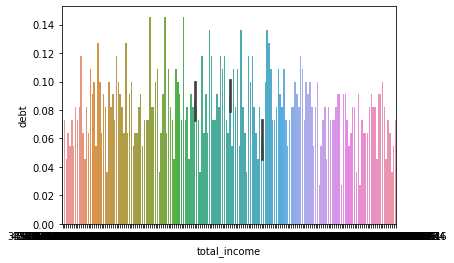

In [22]:
new_data_total_income = data[['total_income', 'debt']].sort_values(by = 'total_income', ascending = True) #сортируем данные, чтобы затем разбить их последовательно  на группы
new_data_total_income['index'] = range(len(data)) #добавляем новое поле, на основании которого будем присваивать категорию (группу). Категоризация проводится по рангу, а не по самой сумме дохода.

def new_category_income(index): #возьмем промежутки по 110 значений, т.к. 21230 делится нацело на 110
    return int((index)/110+1)

new_data_total_income['category'] = new_data_total_income['index'].apply(new_category_income) #заполнили данные о группе в колонке 'category'   

new_data_total_income_plot = pd.pivot_table(new_data_total_income, 
                                            index = 'category', 
                                            values = ['debt', 'total_income'], 
                                            aggfunc= 'mean')
sb.barplot(x = new_data_total_income_plot['total_income'], y = new_data_total_income_plot['debt']) #иллюстрация [не]зависимости средней задержки по кредиту в группах от роста дохода (слева направо)

**Вывод 3:** <br>
На графике мы так же видим, что нет прямой зависимости между доходом и задержкой кредитов, т.к. экстремумы встречаются во всех категориях, хотя и незначительно снижаются в зоне более высоких доходов (справа). <br><br>
**Рекоммендации**: <br> 1) не найдено достаточно оснований для учитывания доходов в расчет индивидуального скоринга.<br>
2) рекоммендуется проверить данные о доходах еще раз и скорректировать их, с учето того, что потери в этих данных составляли порядка 10% и могли существенно повлиять на результаты анализа.

### Вопрос 4:  Как разные цели кредита влияют на его возврат в срок?

purpose_category
операции с автомобилем      0.093236
операции с недвижимостью    0.072596
получение образования       0.092947
проведение свадьбы          0.078730
Name: debt, dtype: float64

<AxesSubplot:ylabel='debt'>

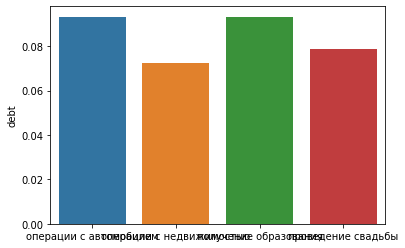

In [23]:
data_purpose = data.groupby(by = 'purpose_category')['debt'].mean()
display(data_purpose)
sb.barplot(x = ['операции с автомобилем', 'операции с недвижимостью','получение образования', "проведение свадьбы"], y = data_purpose)

**Вывод 4:** <br>
На графике мы видим, что операции с автомобилем и получение образования имеют больший процент задержек по сравнению с остальными категориями. <br><br>
**Рекоммендация**: <br> 
рекоммендуется учесть эти категории как категории повышенного риска при расчете индивидуального кредитного скоринга клиентов.

## Общий вывод:


Проведенный анализ данных дал нам следующие результаты и позволил сделать следующие выводы: <br><br>
1. Общий уровень качества данных - удовлетворительный, за исключением столбца dob_years, данные в котором выглядят недостаточно достоверно. Необходимо связаться с разработчиками для детальной проработки этого вопроса.<br><br>
2. Выявлены определенные взаимосвязи между количеством задержек по выплате кредитов в зависимости от семейного положения и количества детей:
- наиболее частую просрочку (по сравнению с другими категориями) показывают категории "не женат/ не замужем" и "гражданский брак"<br>
- наиболее частую просрочку показывают клиенты с детьми<br>
- наиболее частые просрочки случаются при кредитах на операции с автомобилем и на образование.<br>
Рекоммендуется использовать эти данные при расчете индивиуального кредитного скоринга клиентов.<br><br>
3. Не выявлено прямой взаимосвязи между категорией дохода и задержкой по выплате кредита. Это связано с недостаточной репрезентативностью выборки по определенным группам. <br>
Анализ по более узким категориям дохода показал тенденцию к некоторому снижению количества задержек по кредитам при росте дохода клиента. Возможно, потребуется более детальное изучение этой взаимосвязи.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Ты хорошо постаралась, проект отличный и я готов его принять! Однако, я все же отправлю тебе его еще раз, чтобы ознакомиться с результатами проверки) Недостатки указанные желтым цветом можешь учесть и исправить, но настаивать на их отработке я не буду.

<div class="alert alert-info"> <b>Комментарий студента:</b> Большое спасибо за хорошую оценку, я даже не ожидала! Уже после того, как отправила на ревью проект и начала проходить новый модуль, оказалось, что некоторые вещи, которые хотелось сделать в этом анализе, но не знала как или получалось слишком долго / некрасиво, мы оказывается проходим только в следующем блоке! жаль не получилось применить здесь, но надеюсь к следующему проекту это решится. Спасибо еще раз и хорошего дня! </div>